# Outreachy Internships with Wikimedia 
## [Develop a web app for patrolling based on the new ML-based service to predict reverts](https://www.outreachy.org/outreachy-december-2022-internship-round/communities/wikimedia/#develop-a-web-app-for-patrolling-based-on-the-new-)

**Applicant's Name: Claire Sun**

**Github: https://github.com/claire3z**

**Phabricator: @Claire3z**

**Email: claire3z@gmail.com**

*Date of last update: 30-Oct-2022*

In [6]:
# install dependencies
!pip install mwapi
!pip install mwedittypes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.0/59.0 kB 1.6 MB/s eta 0:00:00
  Using cached anytree-2.8.0-py2.py3-none-any.whl (41 kB)


In [ ]:
# import dependencies
import mwapi
import mwedittypes

import asyncio
import aiohttp

import pandas as pd
import time
import json
from ast import literal_eval

from IPython.display import display

# Recent Edits

The [RecentChanges API](https://www.mediawiki.org/wiki/API:RecentChanges) can help you fetch all the recent changes made to a wiki. Here's how you would use [python-mwapi](https://github.com/mediawiki-utilities/python-mwapi#readme), which is a client for the [MediaWiki API](https://www.mediawiki.org/wiki/API:Main_page#Introduction), to get the 3 latest changes made to english wikipedia:

In [225]:
session = mwapi.Session(
    host="https://en.wikipedia.org",
    user_agent="Outreachy round fall 2022"
)
response = session.get(
    action="query",
    list="recentchanges",
    rcprop=["title", "ids", "user", "timestamp","comment","tags"],  # information that we want for every change
    rclimit=3  # no of changes we want
)

response["query"]["recentchanges"]

[{'type': 'edit',
  'ns': 0,
  'title': 'Dene Park',
  'pageid': 71433880,
  'revid': 1116965963,
  'old_revid': 1116122114,
  'rcid': 1561264269,
  'user': 'WikiCleanerBot',
  'timestamp': '2022-10-19T07:19:19Z',
  'comment': 'v2.05b - [[User:WikiCleanerBot#T20|Bot T20 CW#61]] - Fix errors for [[WP:WCW|CW project]] (Reference before punctuation)',
  'tags': ['WPCleaner']},
 {'type': 'categorize',
  'ns': 14,
  'title': 'Category:Avoided double redirects',
  'pageid': 72048216,
  'revid': 1116965961,
  'old_revid': 0,
  'rcid': 1561264271,
  'user': 'AnomieBOT',
  'timestamp': '2022-10-19T07:19:18Z',
  'comment': '[[:1999-00 FIS Alpine Ski World Cup]] added to category, [[Special:WhatLinksHere/1999-00 FIS Alpine Ski World Cup|this page is included within other pages]]',
  'tags': []},
 {'type': 'categorize',
  'ns': 14,
  'title': 'Category:Redirects from modifications',
  'pageid': 72048216,
  'revid': 1116965961,
  'old_revid': 0,
  'rcid': 1561264270,
  'user': 'AnomieBOT',
  'times

Notice that each of those changes has a "type". For our microtasks, we're only interested in the type "edit". The property "ns" means namespace and all encyclopedia articles belong to the "main namespace" or ns 0. You can read through the API documentation linked above to see how to only get changes with properties that we're interested in.

Using this API, fetch the first 5000 edits made to enwiki articles, starting October 6th, 16:00 UTC and try to find:

* The total number of articles the edits were made to.
* The number of unique users making the edits.
* Top 10 articles by number of edits
* Top 10 users by number of edits.



In [94]:
# Testing the Recentchange API using python-mwapi

start = time.time()

session = mwapi.Session(
    host="https://en.wikipedia.org",
    user_agent="Outreachy round fall 2022"
)
response = session.get(
    action="query",
    list="recentchanges",
    rcprop=["title", "ids", "user", "timestamp"],  # information requested for every change/revision
    rcnamespace = 0, # all encyclopedia articles belong to the "main namespace" or ns 0
    rctype = "edit",
    rcstart = "2022-10-06T16:00:00.000Z", #starting October 6th, 16:00 UTC
    rcdir = "newer", # this means getting NEWER changes/revisions AFTER the above timestamp
    rclimit=1,  # num of changes/revisions to get in each request: value must be between 1 and 500.
)

end = time.time()
print('Execution time for a single query session: {} ms'.format(round((end - start)*1000,0)))

#print(response)
#rc0 = response["continue"]["rccontinue"]


Execution time for a single query session: 203.0 ms


In [95]:
start = time.time()

session = mwapi.Session(
    host="https://en.wikipedia.org",
    user_agent="Outreachy round fall 2022"
)

# Getting the first rccontinue for the for-loop to start, since each request can only fetch max 500 results so we need 10 loops.
response = session.get(
    action="query",
    list="recentchanges",
    rcprop=["title", "ids", "user", "timestamp"], 
    rcnamespace = 0, 
    rctype = "edit",
    rcstart = "2022-10-06T16:00:00.000Z",
    rcdir = "newer",
    rclimit=1,  
)

# Save raw results in a list
raw = []
for i in range(10):
    raw.extend(response["query"]["recentchanges"])
    rccontinue = response["continue"]["rccontinue"]
    response = session.get(
        action="query",
        list="recentchanges",
        rcprop=["title", "ids", "user", "timestamp"], 
        rcnamespace = 0, 
        rctype = "edit",
        rcstart = "2022-10-06T16:00:00.000Z", 
        rcdir = "newer",
        rclimit=500,  
        rccontinue = rccontinue, # When more results are available, use this to continue
    )
raw.extend(response["query"]["recentchanges"])

end = time.time()
print('Total execution time for 5,000 edits via synchronous queries: {} s'.format(round((end - start),3)))
#print(len(raw))


Total execution time for 5,000 edits via synchronous queries: 1.117 s


In [98]:
# Save results from the first 5000 edits to a pandas DataFrame for further processing
df = pd.DataFrame(raw[:-1])
df.info()
#df.head()
df.to_csv("enwiki_5000.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   type       5000 non-null   object
 1   ns         5000 non-null   int64 
 2   title      5000 non-null   object
 3   pageid     5000 non-null   int64 
 4   revid      5000 non-null   int64 
 5   old_revid  5000 non-null   int64 
 6   rcid       5000 non-null   int64 
 7   user       5000 non-null   object
 8   timestamp  5000 non-null   object
 9   anon       1203 non-null   object
dtypes: int64(5), object(5)
memory usage: 390.8+ KB


In [620]:
print('--'*50)
print("Overview of Data Collected: First 5000 Edits Made to Enwiki Articles (starting Oct. 6th, 16:00 UTC)")
print('--'*50)

#The total number of articles the edits were made to.
print("\nNumber of unique articles:", df['title'].nunique())

#Top 10 articles by number of edits
print("\nTop 10 articles by number of edits:")
print(df.groupby('title')['rcid'].count().sort_values(ascending=False).head(10))

#The number of unique users making the edits.
print("\nNumber of unique users:", df['user'].nunique())

#Top 10 users by number of edits.
print("\nTop 10 users by number of edits:")
print(df.groupby('user')['rcid'].count().sort_values(ascending=False).head(10))


----------------------------------------------------------------------------------------------------
Overview of Data Collected: First 5000 Edits Made to Enwiki Articles (starting Oct. 6th, 16:00 UTC)
----------------------------------------------------------------------------------------------------

Number of unique articles: 3222

Top 10 articles by number of edits:
title
Landon Collins                 19
Cihan Erdal                    18
IPhone 14 Pro                  17
Tibetan art                    16
RT (TV network)                16
List of Hindi films of 1964    15
Paolo Venini                   15
Palakkad North                 13
Art's Way                      13
WES Commuter Rail              12
Name: rcid, dtype: int64

Number of unique users: 1750

Top 10 users by number of edits:
user
FrescoBot        139
WaddlesJP13       56
HugoAcosta9       55
RobertskySemi     41
Coimenda          34
Datu Hulyo        32
AnomieBOT         31
LBHSMantaRay      30
Denisarona        26

The mwapi client also provides an [AsyncSession](https://github.com/mediawiki-utilities/python-mwapi#asynchronous-single-query) for making asynchronous requests. This can help speed up the process of getting data from an API in some cases. Try using the AsyncSession to query the recentchanges API. 

* Do you see a difference in the total execution time?
* What do you think causes this difference?

In [81]:
start = time.time()

async def query():
    async with aiohttp.ClientSession() as s:
        session = mwapi.AsyncSession(host="https://en.wikipedia.org", user_agent="Outreachy round fall 2022", session=s)
        response = await asyncio.create_task(
            session.get(
                action="query",
                list="recentchanges",
                rcprop=["title", "ids", "user", "timestamp"],  # information that we want for every change
                rcnamespace = 0, #all encyclopedia articles belong to the "main namespace" or ns 0
                rctype = "edit",
                rcstart = "2022-10-06T16:00:00.000Z", #starting October 6th, 16:00 UTC
                rcdir = "newer",
                rclimit=1,  # no of changes we want: first 5000 edits // The value must be between 1 and 500.
            )
        )
await query()
#asyncio.run(query())

end = time.time()
print('Execution time for a single AsyncSession query:{} ms'.format(round((end - start)*1000,0)))



Execution time for AsyncSession query:83.0 ms


In [92]:
start = time.time()
raw = []
async def query():
    async with aiohttp.ClientSession() as s:
        session = mwapi.AsyncSession(host="https://en.wikipedia.org", user_agent="Outreachy round fall 2022", session=s)
        response = await asyncio.create_task(session.get(
                action="query",
                list="recentchanges",
                rcprop=["title", "ids", "user", "timestamp"],  # information that we want for every change
                rcnamespace = 0, #all encyclopedia articles belong to the "main namespace" or ns 0
                rctype = "edit",
                rcstart = "2022-10-06T16:00:00.000Z", #starting October 6th, 16:00 UTC
                rcdir = "newer",
                rclimit=1,  # no of changes we want: first 5000 edits // The value must be between 1 and 500.
        ))
        #raw = []
        for i in range(10):
            raw.extend(response["query"]["recentchanges"])
            rccontinue = response["continue"]["rccontinue"]
            response = await asyncio.create_task(session.get(
                action="query",
                list="recentchanges",
                rcprop=["title", "ids", "user", "timestamp"],  # information that we want for every change
                rcnamespace = 0, #all encyclopedia articles belong to the "main namespace" or ns 0
                rctype = "edit",
                rcstart = "2022-10-06T16:00:00.000Z", #starting October 6th, 16:00 UTC
                rcdir = "newer",
                rclimit=500,  # no of changes we want: first 5000 edits // The value must be between 1 and 500.
                rccontinue = rccontinue,
            ))
        raw.extend(response["query"]["recentchanges"])
        
await query()

end = time.time()
print('Total execution time for first 5,001 edits via asynchronous queries: {} s'.format(round((end - start),3)))
#print(len(raw))


Total execution time for first 5,001 edits via asynchronous queries: 1.048 s


**Observations / Comments** 

It seems that an asynchronous session executes faster than a synchronous one:
 - Execution time for a single query: 83ms (asynchronous) vs 203ms (synchronous)
 - Total execution time for 5000 edits: 1.048s (asynchronous) vs 1.117s (synchronous)

Some possible explanation for the faster execution time is that asynchronous client API is designed to make the most out of non-blocking network operations in asynchronous programming[1]. This means concurrent code written in async/await syntax can be run in multi-threads and respond to other events, rather than having to wait for one single task to finish.

***Disclaimer***: I am not an expert on synchronous vs asynchronous programming and I am still learning/researching about this topic.

*Reference:*
1. *[The aiohttp Request Lifecycle](https://docs.aiohttp.org/en/latest/http_request_lifecycle.html)* 
2. *[Source code for mwapi AsyncSession](https://github.com/mediawiki-utilities/python-mwapi/blob/master/mwapi/async_session.py)*
3. *[Python doc: asyncio-Asynchronous I/O](https://docs.python.org/3/library/asyncio.html)*


# Damaging Edits

On Wikipedia, reverting means undoing or otherwise negating the effects of one or more edits, which restores the page to a previous version. Edits can get reverted for being unsourced, biased or, malicious among other reasons. 

Assuming that most damaging edits will get reverted, you can use the [ORES API](https://www.mediawiki.org/wiki/ORES#API_usage) to predict how many of the edits that you've sampled are likely to be reverted using the "damaging" model. Once you have the scores for all edits, try summarizing them using statistics.

In [281]:
import requests
import matplotlib.pyplot as plt

In [188]:
# get model prediction, probablity and features
def ores_model_get_results(revids):
    '''Ores API recommends to process a batch of no more than 50 revisions within a given request
    '''
    prediction = []
    probability = []
    features = []
    batches = [revids[i:i+50] for i in range(0,len(revids),50)]
    for batch_ids in batches:
        revids_ = '|'.join(batch_ids)
        api_url = "https://ores.wikimedia.org/v3/scores/enwiki/?models=damaging&revids={}&features".format(revids_)
        #api_url = "https://ores.wikimedia.org/v3/scores/enwiki/{}/damaging?features".format(revids_)
        response = requests.get(api_url)
        scores = response.json()['enwiki']['scores']
        for revid in batch_ids:
            try:
                prediction.append(scores[revid]['damaging']['score']['prediction'])
                probability.append(scores[revid]['damaging']['score']['probability'])
                features.append(scores[revid]['damaging']['features'])
            except KeyError:
                #print(revid, scores[revid])
                prediction.append(scores[revid]['damaging']['error']['type'])
                probability.append(None)
                features.append(None)
    return prediction, probability, features
                                

#ores_model_get_results(df['revid'].astype('string').to_list()[:10])


In [294]:
df_2 = pd.read_csv('enwiki_5000_v2.csv')

df_2['modelPredict'],df_2['probability'],df_2['features'] = ores_model_get_results(df_2['revid'].astype('string').to_list())
df_2 = pd.concat([df_2,pd.json_normalize(df_2['probability']),pd.json_normalize(df_2['features'])],axis=1)

df_2.to_csv("enwiki_5000_v2.csv")

In [303]:
df_2.columns

Index(['Unnamed: 0', 'type', 'ns', 'title', 'pageid', 'revid', 'old_revid',
       'rcid', 'user', 'timestamp', 'comment', 'tags', 'anon', 'modelPredict',
       'probability', 'features', 'false', 'true',
       'feature.english.badwords.revision.diff.match_delta_decrease',
       'feature.english.badwords.revision.diff.match_delta_increase',
       'feature.english.badwords.revision.diff.match_delta_sum',
       'feature.english.badwords.revision.diff.match_prop_delta_decrease',
       'feature.english.badwords.revision.diff.match_prop_delta_increase',
       'feature.english.badwords.revision.diff.match_prop_delta_sum',
       'feature.english.dictionary.revision.diff.dict_word_delta_decrease',
       'feature.english.dictionary.revision.diff.dict_word_delta_increase',
       'feature.english.dictionary.revision.diff.dict_word_delta_sum',
       'feature.english.dictionary.revision.diff.dict_word_prop_delta_decrease',
       'feature.english.dictionary.revision.diff.dict_word_prop_d

In [158]:
# REF. https://www.mediawiki.org/wiki/ORES#API_usage
#api_url = "https://ores.wikimedia.org/v3/scores/wikidatawiki/1114606853/damaging"
#response = requests.get(api_url)
#print(response.json())
#response.json()['wikidatawiki']['scores'][revid]['damaging']['score']['prediction']

def ores_model_predicts(revids):
    '''Ores API recommends to process a batch of no more than 50 revisions within a given request
    '''
    prediction = []
    batches = [revids[i:i+50] for i in range(0,len(revids),50)]
    for batch_ids in batches:
        revids_ = '|'.join(batch_ids)
        api_url = "https://ores.wikimedia.org/v3/scores/enwiki/?models=damaging&revids="+revids_
        response = requests.get(api_url)
        scores = response.json()['enwiki']['scores']
        for revid in batch_ids:
            try:
                prediction.append(scores[revid]['damaging']['score']['prediction'])
            except KeyError:
                #print(revid, scores[revid])
                prediction.append(scores[revid]['damaging']['error']['type'])

    return prediction


In [159]:
df['modelPredict'] = ores_model_predicts(df['revid'].astype('string').to_list())
df.head()

1114458722 {'damaging': {'error': {'message': 'TextDeleted: Text deleted (datasource.revision.parent.text)', 'type': 'TextDeleted'}}}
1114459339 {'damaging': {'error': {'message': 'TextDeleted: Text deleted (datasource.revision.text)', 'type': 'TextDeleted'}}}
1114459964 {'damaging': {'error': {'message': 'TextDeleted: Text deleted (datasource.revision.parent.text)', 'type': 'TextDeleted'}}}
1114461707 {'damaging': {'error': {'message': 'TextDeleted: Text deleted (datasource.revision.text)', 'type': 'TextDeleted'}}}
1114461969 {'damaging': {'error': {'message': 'TextDeleted: Text deleted (datasource.revision.parent.text)', 'type': 'TextDeleted'}}}
1114467492 {'damaging': {'error': {'message': 'TextDeleted: Text deleted (datasource.revision.text)', 'type': 'TextDeleted'}}}


,type,ns,title,pageid,revid,old_revid,rcid,user,timestamp,anon,modelPredict
0,edit,0,Steve Orlando,57068776,1114458408,1113229003,1556978406,Omnipaedista,2022-10-06T16:00:01Z,NaN,False
1,edit,0,Rockstar Lincoln,7365848,1114458409,1112107654,1556978425,PerryPerryD,2022-10-06T16:00:01Z,NaN,False
2,edit,0,"Burma Valley, Zimbabwe",994296,1114458410,950859137,1556978417,Vanspoof,2022-10-06T16:00:02Z,NaN,False
3,edit,0,Clarknova,7881567,1114458412,1079337842,1556978422,SimLibrarian,2022-10-06T16:00:02Z,NaN,False
4,edit,0,Wang Lixiong,12928235,1114458414,1019746380,1556978424,Randy Kryn,2022-10-06T16:00:03Z,NaN,False


In [702]:
bad_edits = df[df['modelPredict']==True]['revid'].count()
total_edits = df['revid'].count()
print(bad_edits, total_edits)

379 5000


----------------------------------------------------------------------------------------------------
Overview of ORES Model Prediction on the 5000 Edits Collected
----------------------------------------------------------------------------------------------------
Distribution of prediction results (%):
False          92.30
True            7.58
TextDeleted     0.12
Name: modelPredict, dtype: float64

Frequency of damaging edits occurring:


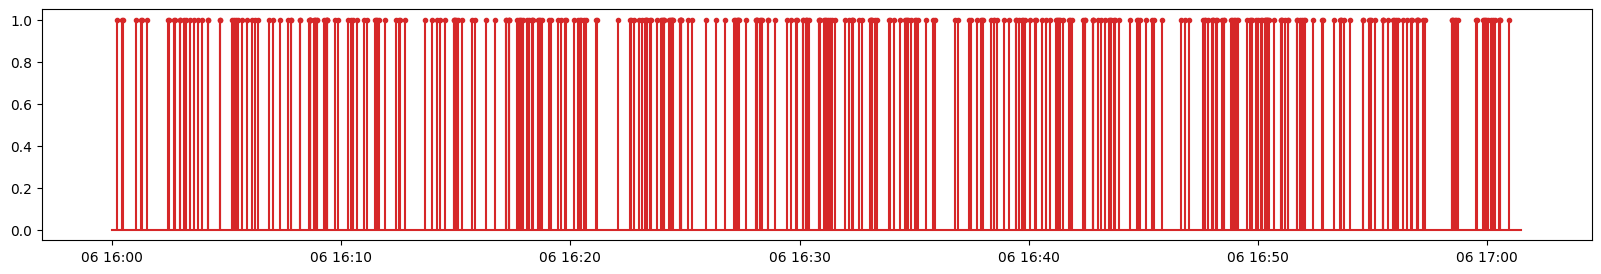


Number of damaging edits: 379 (7.6% of total 5000 edits)

Number of unique titles subjected to damaging edits: 300 (9.3% of total 3222 unique titles)

Number of unique users responsible for damaging edits: 277 (15.8% of total 1750 unique users)

Top 10 most-edited titles:


,total_edits,damaging_edits,pct_damaging
title,,,
Landon Collins,19,7,0.368421
IPhone 14 Pro,17,7,0.411765
Nicolas Sarkozy,11,2,0.181818
Rorschach (film),11,1,0.090909
Alan Harding,10,3,0.300000
Turkish Radio and Television Corporation,9,3,0.333333
Jean Christophe Iseux von Pfetten,7,3,0.428571
Raymond Appert,7,1,0.142857
Jenkins,7,4,0.571429



Top 30 users by number of damaging edits:


user
46.39.45.187                               8
182.1.190.243                              7
217.33.165.88                              5
24.254.177.205                             5
89.101.237.102                             4
162.217.51.184                             4
2601:603:A7F:5580:2C4F:7516:AE42:53CD      4
80.233.45.111                              4
195.43.48.138                              3
69.64.109.228                              3
2600:1700:37E1:7800:3D21:BA54:945C:5973    3
2405:201:E026:FD1C:BDA3:964B:553B:E312     3
50.233.121.186                             3
2.26.229.68                                3
150.221.146.80                             3
C.cunninghamDLT                            3
150.176.146.140                            3
Gaganpreet Singh Gill                      3
88.241.169.63                              3
76.94.59.40                                3
207.32.160.247                             3
206.226.69.98                              2
8.43.

In [711]:
# Statistics of model prediction

bad_edits = df[df['modelPredict']==True]['revid'].count()
total_edits = df['revid'].count()

bad_titles = df[df['modelPredict']==True]['title'].nunique()
total_titles = df['title'].nunique()

bad_users = df[df['modelPredict']==True]['user'].nunique()
total_users = df['user'].nunique()


print('--'*50)
print("Overview of ORES Model Prediction on the 5000 Edits Collected")
print('--'*50)

# Prediction: True/False/TextDeleted
print("Distribution of prediction results (%):")
print(df['modelPredict'].value_counts()/5000*100)

print("\nFrequency of damaging edits occurring:")
df['timestamp'].astype('datetime64')[100]-df['timestamp'].astype('datetime64')[0]
plt.figure(figsize=(20,3))
plt.stem(df['timestamp'].astype('datetime64'),df['modelPredict'].map({True:1}),markerfmt='C3.',linefmt='C3-')
plt.show()


#print("\nFrequency of good edits occurring:") --> Does not show meaningful pattern
#df['timestamp'].astype('datetime64')[100]-df['timestamp'].astype('datetime64')[0]
#plt.figure(figsize=(20,3))
#plt.stem(df['timestamp'].astype('datetime64'),df['modelPredict'].map({False:1}),markerfmt='C0.',linefmt='C0.')
#plt.show()

print("\nNumber of damaging edits: {} ({}% of total {} edits)".format(bad_edits,round(bad_edits/total_edits*100,1),total_edits))
print("\nNumber of unique titles subjected to damaging edits: {} ({}% of total {} unique titles)".format(bad_titles,round(bad_titles/total_titles*100,1),total_titles))
print("\nNumber of unique users responsible for damaging edits: {} ({}% of total {} unique users)".format(bad_users,round(bad_users/total_users*100,1),total_users))

n = 10
print("\nTop {} most-edited titles:".format(n))
#print(df[df['modelPredict']==True].groupby('title')['title'].count().sort_values(ascending=False).head(10))
df_bad_titles = pd.DataFrame(columns=['total_edits','damaging_edits','pct_damaging'])
df_bad_titles['damaging_edits'] = df[df['modelPredict']==True].groupby('title')['title'].count()
df_bad_titles['total_edits'] = df[df['title'].isin(df_bad_titles.index)].groupby('title')['revid'].count()
df_bad_titles['pct_damaging'] = df_bad_titles['damaging_edits']/df_bad_titles['total_edits'] 
display(df_bad_titles.sort_values(by='total_edits',ascending=False).head(n))

n = 30
print("\nTop {} users by number of damaging edits:".format(n))
display(df[df['modelPredict']==True].groupby('user')['user'].count().sort_values(ascending=False).head(n))

<br>

**Observations / Comments** 
 - c. 7.6% of total edits are predicted as 'damaging' by the ORES model. This is an imbalanced classification problem / fraud detection    
 - The damaging edits occurred throughout the hour with no particularly noticable frequency pattern (at least for the 5000 data points collected)   
 - The more popularly edited titles are more likely to be the targets of damaging edits, for instance, all of the top 10 titles (by number of edits) have suffered from damaging edits.
 - Most of the users responsible for the damaging edits are anonymous (i.e., only known by an IP address); in contrast, most of the good faith users have a proper user ID. 
 - We could potentially use the user ID as a feature (e.g. constructing regex rules for IP addresses) to identify damaging edits. However, it should also be noted that some legid edits are also done by IP-address based users.


In [160]:
# Saving model prediction
df.to_csv("enwiki_5000.csv")

# Comparing edits

For the revisions that you sampled from Recent Changes, compare each to its parent revision (`old_revid` from RecentChanges response) and try to find some similarities and differences between them. For example, you can try finding:

* If they were made by the same or different users
* How far apart the two edits were made

In addition to comparing the metadata, it can also be helpful to compare the content of the revisions too. One way of doing that would be using the [mwedittypes](https://github.com/geohci/edit-types#mwedittypes) package that helps summarize the changes made by an edit to the content of an article. Here's an example of how to compare the wikitext of two revisions 

In [4]:
prev_wikitext = '{{Short description|Austrian painter}}'
curr_wikitext = '{{Short description|Austrian [[landscape painter]]}}'

et = mwedittypes.SimpleEditTypes(prev_wikitext, curr_wikitext, lang='en')
et.get_diff()

{'Wikilink': {'insert': 1},
 'Section': {'change': 1},
 'Template': {'change': 1}}

Feel free to compare other features of the edits than just the ones above. Also, use any visualizations here that you think would be helpful!

In [244]:
# Add more attributes to dataset: 'old_user' to compare with df['user'], 'old_timestamp' to compare with df['timestamp']; 
# Use 'old_revid' from existing dataset to get old_user and old_timestamp 

session = mwapi.Session(
    host="https://en.wikipedia.org",
    user_agent="Outreachy round fall 2022"
)

def mwapi_getRevision(revids):
    """Get user and timestamp information from revids"""
    response = session.get(
        action='query', prop='revisions', revids=revids)

    for page_doc in response['query']['pages']:
        revision = response['query']['pages'][page_doc]['revisions'][0]

    return revision['user'],revision['timestamp']


df['old_user'],df['old_timestamp'] = zip(*df['old_revid'].map(mwapi_getRevision))
df.to_csv("enwiki_5000.csv")
df.head()

,type,ns,title,pageid,revid,old_revid,rcid,user,timestamp,anon,modelPredict,old_user,old_timestamp
0,edit,0,Steve Orlando,57068776,1114458408,1113229003,1556978406,Omnipaedista,2022-10-06T16:00:01Z,NaN,False,FilmLover72,2022-09-30T12:41:38Z
1,edit,0,Rockstar Lincoln,7365848,1114458409,1112107654,1556978425,PerryPerryD,2022-10-06T16:00:01Z,NaN,False,IceWelder,2022-09-24T18:10:25Z
2,edit,0,"Burma Valley, Zimbabwe",994296,1114458410,950859137,1556978417,Vanspoof,2022-10-06T16:00:02Z,NaN,False,Tom Radulovich,2020-04-14T06:23:59Z
3,edit,0,Clarknova,7881567,1114458412,1079337842,1556978422,SimLibrarian,2022-10-06T16:00:02Z,NaN,False,Premeditated Chaos,2022-03-26T07:17:02Z
4,edit,0,Wang Lixiong,12928235,1114458414,1019746380,1556978424,Randy Kryn,2022-10-06T16:00:03Z,NaN,False,GreenC bot,2021-04-25T05:05:06Z


In [713]:
df_damage = df[df['modelPredict']==True]
total = df_damage['user'].count()
same_users = df_damage[df_damage['user'] ==df_damage['old_user']]['user'].count()
print("\nOut of a total of {} damaging edits, {} are performed by the same users as the previous revision (c. {}%)".format(total, 
      same_users, round(same_users/total*100,1)))


diff = (pd.to_datetime(df_damage['timestamp'],utc=True) - pd.to_datetime(df_damage['old_timestamp'],utc=True)).astype('timedelta64[h]')
same_day = (diff < 24).sum()
print("\nOut of a total of {} damaging edits, {} are performed within 24 hours from the previous revision (c. {}%)".format(total, 
      same_day, round(same_day/total*100,1)))

print("\nDistribution of time difference between two subsequent revisions:")
print(diff.describe())




Out of a total of 379 damaging edits, 104 are performed by the same users as the previous revision (c. 27.4%)

Out of a total of 379 damaging edits, 175 are performed within 24 hours from the previous revision (c. 46.2%)

Distribution of time difference between two subsequent revisions:
count      379.000000
mean       946.073879
std       2793.151744
min          0.000000
25%          0.000000
50%         49.000000
75%        532.000000
max      19162.000000
dtype: float64


In [ ]:
#Compare the content of the revisions using the mwedittypes package 

def getContentDiff(row):

    try:
        response_curr = session.get(action='query', prop='revisions', rvslots='main',revids=row['revid'],rvprop='content')
        for k in response_curr['query']['pages'].keys():
            current = response_curr['query']['pages'][k]['revisions'][0]['slots']['main']['*']
    except KeyError:
        #print('current:',row['revid'], response_curr['query']['pages'][k]['revisions'][0])
        # If the content has been revision deleted, a texthidden property will be returned.
        current ={}
    
    
    try:
        response_prev = session.get(action='query', prop='revisions', rvslots='main',revids=row['old_revid'],rvprop='content')
        for k in response_prev['query']['pages'].keys():
            previous = response_prev['query']['pages'][k]['revisions'][0]['slots']['main']['*']
    except KeyError:
        #print('old:', row['old_revid'], response_prev['query']['pages'][k]['revisions'][0])
        previous ={}

    et = mwedittypes.SimpleEditTypes(previous, current, lang='en')
    
    try:
        diff = et.get_diff()
    except AttributeError:
        diff = {}
        #print('old: ', previous[:100],'\ncurrent:',current[:100])
        
    return diff 


#getContentDiff(df.loc[0])

df['ContentDiff'] = df.apply(lambda row: getContentDiff(row),axis = 1)

df.to_csv("enwiki_5000.csv")


In [723]:
# Patterns of Good Edits
print('Patterns of Content Difference for Good Edits:\n')
print(df[df['modelPredict']==False]['ContentDiff'].describe())
print('\nTop 10 Good Patterns by frequency:\n')
print(df[df['modelPredict']==False]['ContentDiff'].value_counts(normalize=True)[:10])

# Patterns of Damaging Edits
print('\n\nPatterns of Content Difference for Damaging Edits:\n')
print(df[df['modelPredict']==True]['ContentDiff'].describe())
print('\nTop 10 Bad Patterns by frequency:\n')
print(df[df['modelPredict']==True]['ContentDiff'].value_counts(normalize=True)[:10])

# Comparing Good vs Damanging
a = df[df['modelPredict']==True]['ContentDiff'].value_counts()
b = df[df['modelPredict']==False]['ContentDiff'].value_counts()
# Common set of patterns for both good and damaging revisions
#a.index.astype('string').intersection(b.index.astype('string'))
# Unique patterns for only damaging revisions
c= a.index.astype('string').difference(b.index.astype('string'),sort=False) # do not sort and return the index in order of dataframe b
print("\n\nThere are {} unique patterns in the damaging revision set which are not present in the good set.".format(len(c)))
print("\nTop 10 Bad-Only Patterns patterns (not present in Good Patterns)")
print(c[:10])


Patterns of Content Difference for Good Edits:

count                                                  4615
unique                                                 2511
top       {'Template': {'change': 1}, 'Section': {'chang...
freq                                                    324
Name: ContentDiff, dtype: object

Top 10 Good Patterns by frequency:

{'Template': {'change': 1}, 'Section': {'change': 1}}                                                       0.070206
{'Section': {'change': 1}, 'Word': {'change': 1}, 'Sentence': {'change': 1}, 'Paragraph': {'change': 1}}    0.034886
{'Category': {'insert': 1}, 'Section': {'change': 1}, 'Whitespace': {'insert': 1}}                          0.023185
{'Template': {'insert': 1}, 'Section': {'change': 1}, 'Whitespace': {'insert': 1}}                          0.022535
{'Wikilink': {'insert': 1}, 'Section': {'change': 1}}                                                       0.016901
{'Wikilink': {'change': 1}, 'Section': {'change': 1}}    

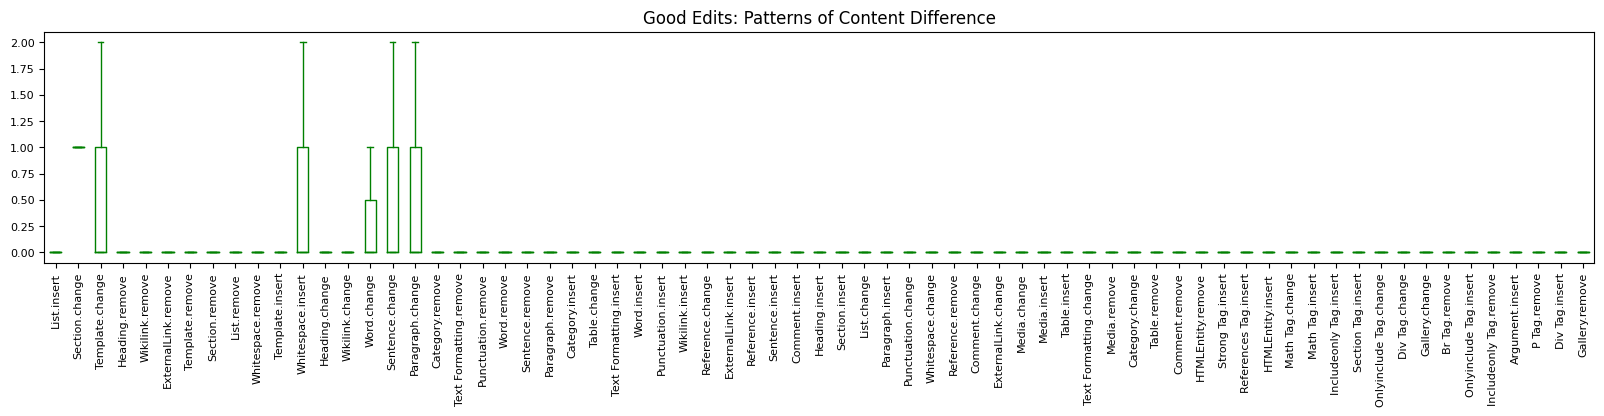

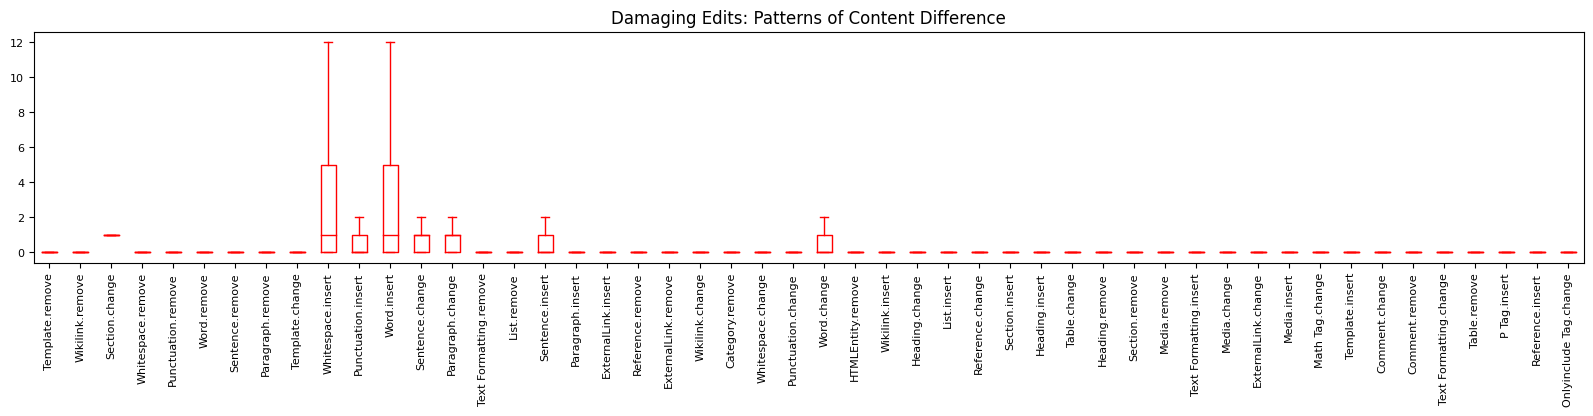

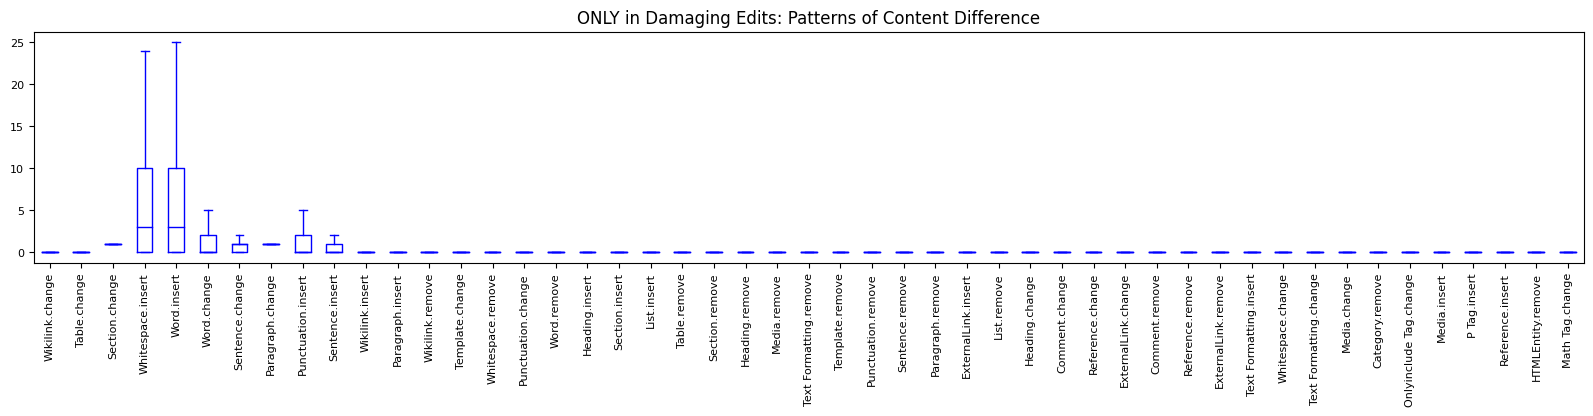

In [742]:
# Data Visualization of Good Patterns vs Bad Patterns

# Expand df['ContentDiff'] into columns
#pd.json_normalize(c.map(lambda x: json.loads(x.replace("'","\""))).to_series()).fillna(0)
t = pd.json_normalize(df[df['modelPredict']==True]['ContentDiff']).fillna(0)
f = pd.json_normalize(df[df['modelPredict']==False]['ContentDiff']).fillna(0)
badOnly = pd.json_normalize(c.map(lambda x: json.loads(x.replace("'","\""))).to_series()).fillna(0)

f.boxplot(showfliers=False,grid=False,rot=90, fontsize=8, color='g',figsize=(20,3))
plt.title('Good Edits: Patterns of Content Difference')
plt.show()

t.boxplot(showfliers=False,grid=False,rot=90, fontsize=8, color='r',figsize=(20,3))
plt.title('Damaging Edits: Patterns of Content Difference')
plt.show()

badOnly.boxplot(showfliers=False,grid=False,rot=90, fontsize=8, color='b',figsize=(20,3))
plt.title('ONLY in Damaging Edits: Patterns of Content Difference')
plt.show()


<br>

**Observations / Comments** 
 - There are a lot of overlapping patterns for both good edits and damaging edits when comparing the content difference vs previous change, for example, *whitespace insert, paragraph change, word change*, etc.
 - However, numbers of changes in damaging edits tend to be much larger than in good edits (1~2), as shown by the box plots above, e.g. *whitespace insert*. 
 - This is especially evidenced by observing the patterns only present in damaging edits (bottom chart, notice the scale of axis)
 - From this, we could identify certain features in the pattern change which are more likely to indicate damaging edits when above some thresholds, e.g. *whitespace insert, word insert, punctuation insert, sentence insert, paragraph change, word change*, etc.

# Additional Attributes

There are additional attributes associated with each edits, such as comments, tags and change size, which might be helpful in determining whether an edit is damaging. The hypothesis is that damaging edits are less likely to have comments and tags. It might also be interesting to see whether there is any correlation between size of the change and quality of edits (good vs damaging)



In [ ]:
# Get additional attributes - comment, tags and change size

def getComments(revid):
    response = session.get(
        action='query', prop='revisions', rvslots='main',revids=revid,rvprop='comment|tags|size')
    try:
        for page_doc in response['query']['pages']:
            revision = response['query']['pages'][page_doc]['revisions'][0]
        return revision['comment'],revision['tags'],revision['size']
    
    except KeyError:
        return None,None,None
        
#df['revid'][-25:-20].map(getComments)
df['comment'],df['tags'], df['change_size']= zip(*df['revid'].map(getComments))
df.to_csv("enwiki_5000.csv")


In [781]:
df[['modelPredict','comment','tags','change_size']].head()

,modelPredict,comment,tags,change_size
0,False,/* External links */,[wikieditor],25750.0
1,False,/* Bibliography */ Removing Blacklisted Source...,[visualeditor-wikitext],23722.0
2,False,#suggestededit-add 1.0,"[mobile edit, mobile app edit, android app edit]",1194.0
3,False,,"[mobile edit, mobile app edit, ios app edit]",5188.0
4,False,"/* Social Activities */ sentence case, upperca...",[],12084.0


In [923]:
bad_tags = pd.get_dummies(df[df['modelPredict']==True]['tags'].apply(pd.Series),prefix='', prefix_sep='').sum()
bad_tags = bad_tags.groupby(bad_tags.index).sum().sort_values(ascending=False) /len(df[df['modelPredict']==True])*100
print("\nTop 10 Tags for damaging edits (as % of total)")
print(bad_tags.head(10))

good_tags = pd.get_dummies(df[df['modelPredict']==False]['tags'].apply(pd.Series),prefix='', prefix_sep='').sum()
good_tags = good_tags.groupby(good_tags.index).sum().sort_values(ascending=False)/len(df[df['modelPredict']==False])*100
print("\n\nTop 10 Tags for good edits (as % of total)")
print(good_tags.head(10))



Top 10 Tags for damaging edits (as % of total)
wikieditor                51.978892
mw-reverted               50.923483
mobile edit               35.620053
mobile web edit           34.036939
visualeditor              18.733509
newcomer task              2.638522
references removed         2.638522
newcomer task copyedit     1.846966
mw-manual-revert           1.846966
mobile app edit            1.583113
dtype: float64


/tmp/ipykernel_85/4061353737.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  good_tags = pd.get_dummies(df[df['modelPredict']==False]['tags'].apply(pd.Series),prefix='', prefix_sep='').sum()
/tmp/ipykernel_85/4061353737.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  good_tags = pd.get_dummies(df[df['modelPredict']==False]['tags'].apply(pd.Series),prefix='', prefix_sep='').sum()




Top 10 Tags for good edits (as % of total)
wikieditor               54.474540
mobile edit              17.183099
mobile web edit          14.669556
visualeditor             11.570964
mw-reverted               7.670639
mw-undo                   5.785482
advanced mobile edit      2.795233
mobile app edit           2.513543
twinkle                   2.231853
visualeditor-wikitext     1.668472
dtype: float64



Empty Comment: 44.3% of damaging edits do not have any comment vs 22.3% in good edits

Tags: Damaging edits tend to be more likely associated with certain tags than good edits


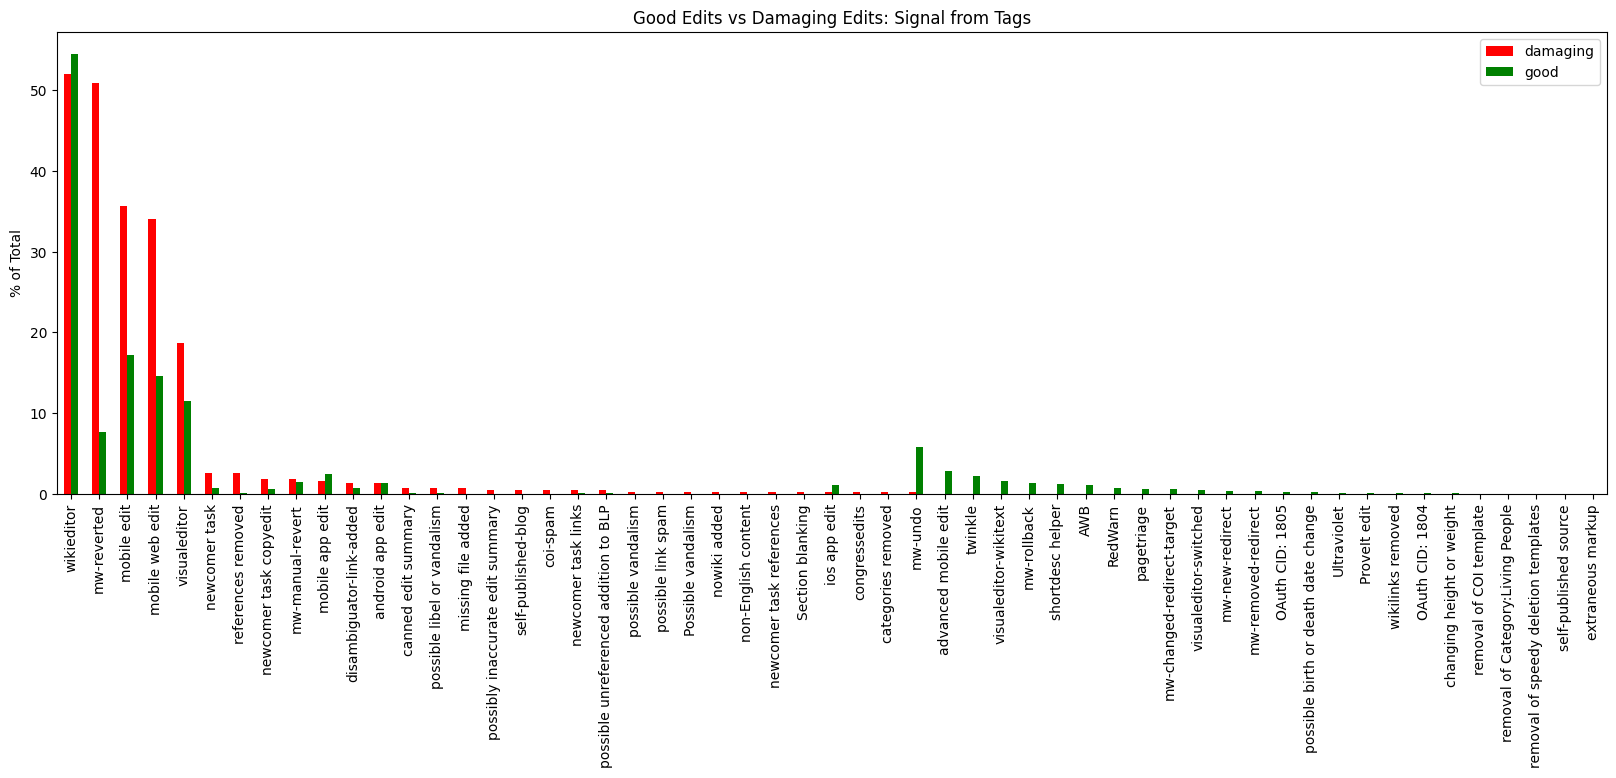


Change Size: similar distribution for both edits and damaging edits; not an obvious feature choice


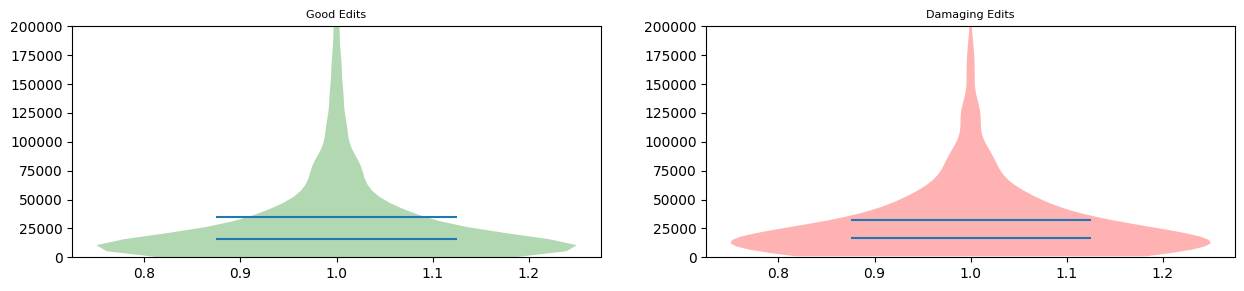

In [944]:
# Data summary

# % of damaging edits do not have any comment vs % for good edits
nocomment_bad = df[df['modelPredict']==True].loc[df['comment'] =='']['revid'].count() / df[df['modelPredict']==True]['revid'].count() 
nocomment_good = df[df['modelPredict']==False].loc[df['comment'] =='']['revid'].count() / df[df['modelPredict']==False]['revid'].count()
print("\nEmpty Comment: {}% of damaging edits do not have any comment vs {}% in good edits".format(round(nocomment_bad*100,1), round(nocomment_good*100,1)))

# visualization of tag signals 
print("\nTags: Damaging edits tend to be more likely associated with certain tags than good edits")
tags = pd.concat([bad_tags, good_tags], axis = 1, sort = False).fillna(0)
tags.columns = ['damaging','good']
tags.plot.bar(color={'damaging':'red','good':'green'},figsize=(20,6),title='Good Edits vs Damaging Edits: Signal from Tags',ylabel='% of Total')
plt.show()

# visualization of change_size 
print("\nChange Size: similar distribution for both edits and damaging edits; not an obvious feature choice") 
fig,ax = plt.subplots(1,2, figsize=(15,3))
#df[df['modelPredict']==True]['change_size'].hist(ax=ax[0])
#df[df['modelPredict']==False]['change_size'].hist(ax=ax[1])

x = ax[0].violinplot(df[df['modelPredict']==False]['change_size'].fillna(0),showmeans=True, showextrema=False, showmedians=True)
ax[0].set_title('Good Edits', fontsize=8)
ax[0].set_ylim([0, 200000])
for pc in x['bodies']:
    pc.set_facecolor('green')


x = ax[1].violinplot(df[df['modelPredict']==True]['change_size'].fillna(0), showmeans=True, showextrema=False, showmedians=True)
ax[1].set_title('Damaging Edits', fontsize=8)
ax[1].set_ylim([0, 200000])
for pc in x['bodies']:
    pc.set_facecolor('red')
    

# Analysis

Now that you've found ways to quantify differences between revisions, what observations can you make about edits that are likely to be reverted. Are there certain types of differences associated with edits that are "damaging" according to ORES? 

**Observation Summary** 
 - c. 7.6% of total edits are predicted as 'damaging' by the ORES model. This is an imbalanced classification problem / fraud detection    
 - The damaging edits occurred throughout the hour with no particularly noticable frequency pattern (at least for the 5000 data points collected)   
 - The more popularly edited titles are more likely to be the targets of damaging edits, for instance, all of the top 10 titles (by number of edits) have suffered from damaging edits.
 - Most of the users responsible for the damaging edits are anonymous (i.e., only known by an IP address); in contrast, most of the good faith users have a proper user ID. 
 - We could potentially use the user ID as a feature (e.g. constructing regex rules for IP addresses) to identify damaging edits. However, it should also be noted that some legid edits are also done by IP-address based users.
 
 - There are a lot of overlapping patterns for both good edits and damaging edits when comparing the content difference vs previous change, for example, *whitespace insert, paragraph change, word change*, etc. However, numbers of changes in damaging edits tend to be much larger than in good edits (1~2), as shown by the box plots above, e.g. *whitespace insert*. 
 - From this, we could identify certain features in the pattern change which are more likely to indicate damaging edits when above some thresholds, e.g. *whitespace insert, word insert, punctuation insert, sentence insert, paragraph change, word change*, etc.

 - Additional attributes such as empty comment and certain tags (e.g. *mv-reverted*, *mobile edit*, *mobile web edit*) should also be considered as distinguishing features between damaging edits and good edits. 

 - Moreover, it seems the correlation between size of the change and quality of edits are not very strong (subject to further testing)



# <span style="color:blue">Additional Analysis (Post Initial Feedback from Mentor)</span> 

In [199]:
import pandas as pd
import time
import json
from ast import literal_eval
import matplotlib.pyplot as plt
import requests

In [135]:
# load data again
df = pd.read_csv("enwiki_5000.csv")

# remove missing data
print('Model prediction:\n', df['modelPredict'].value_counts(),'\n\n') 
df = df[df['modelPredict']!='TextDeleted'][['modelPredict','title','pageid','revid','old_revid','rcid','user','timestamp','old_user','old_timestamp','ContentDiff','comment','tags','change_size']]

print('Missing values:\n', df.isna().sum(),'\n\n')  

df = df.dropna(subset = ['tags','change_size'])
df.info()

Model prediction:
 False          4615
True            379
TextDeleted       6
Name: modelPredict, dtype: int64 


Missing values:
 modelPredict        0
title               0
pageid              0
revid               0
old_revid           0
rcid                0
user                0
timestamp           0
old_user            0
old_timestamp       0
ContentDiff         0
comment          1200
tags                1
change_size         1
dtype: int64 


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4993 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   modelPredict   4993 non-null   object 
 1   title          4993 non-null   object 
 2   pageid         4993 non-null   int64  
 3   revid          4993 non-null   int64  
 4   old_revid      4993 non-null   int64  
 5   rcid           4993 non-null   int64  
 6   user           4993 non-null   object 
 7   timestamp      4993 non-null   objec

## <span style="color:blue">Preliminary Feature Selection</span>
 - whether user_id is an IP address (True/False) - regex patterns 
 - whether the same user as previous edit (True/False) - user vs old_user 
 - time difference vs previous edit (numerical value in minutes) - timestamp vs old_timestamp / OR consider a threshold value? 
 - whether the edits has empty comments (True/False)
 - size of changes (numerical value) - not sure how significant
 - content difference {'whitespace.insert', '', etc.} (numerical value) - json_normalize
 - tags {'mw-revert', 'mobile edit', etc.} - identify categories
 

In [136]:
# user_id: whether user_id is an IP address (True/False) - regex patterns
#sum(df['user'].str.count('\.')==3),sum(df['user'].str.count('\:')==7)  #(886, 317)
df['user_ip'] = (df['user'].str.count('\.')==3) | (df['user'].str.count('\:')==7)

# same_user: Same user as previous edit (True/False) - user vs old_user
df['sameUser'] = df['user'] == df['old_user']

# no_comment: whether the edits has empty comments (True/False)
df['noComment'] = df['comment'].isnull()

# time_lag: time lags vs previous edit (numerical value in minutes) - timestamp vs old_timestamp / OR consider a threshold value?
df['timeDiff'] = (pd.to_datetime(df['timestamp'],utc=True) - pd.to_datetime(df['old_timestamp'],utc=True)).astype('timedelta64[m]')
df['timeDiff_1m'] = df['timeDiff']>1 
df['timeDiff_1h'] = df['timeDiff']>60
df['timeDiff'] = df['timeDiff']/df['timeDiff'].max()

df['change_size_normalize'] = df['change_size'].fillna(0) / df['change_size'].max()


In [137]:
# select top 3 tags
# .apply(literal_eval)
dummy = pd.get_dummies(df['tags'].apply(literal_eval).apply(pd.Series),prefix='', prefix_sep='')#[['mw-reverted','mobile edit','mobile web edit']]
print(len(dummy.columns), len(dummy.columns.unique()))
df['tag_mw-reverted'] = dummy['mw-reverted'].sum(axis=1) > 0 
df['tag_mobile edit'] = dummy['mobile edit'].sum(axis=1)> 0
df['tag_mobile web edit'] = dummy['mobile web edit'].sum(axis=1)> 0

/tmp/ipykernel_103/296741550.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dummy = pd.get_dummies(df['tags'].apply(literal_eval).apply(pd.Series),prefix='', prefix_sep='')#[['mw-reverted','mobile edit','mobile web edit']]


117 55


In [154]:
# select top 3 content changes

dummy = pd.json_normalize(df['ContentDiff'].astype('string').map(lambda x: json.loads(x.replace("'","\"")))).fillna(0)

df['Whitespace.remove'] = dummy['Whitespace.remove']/dummy['Whitespace.remove'].max()
df['Word.remove'] = dummy['Word.remove']/dummy['Word.remove'].max()
df['Template.remove'] = dummy['Template.remove']/dummy['Template.remove'].max()

df = df.dropna(subset=['Whitespace.remove','Word.remove','Template.remove'])
print(len(df))

4986


Feature 0 (user_ip): 667.9
Feature 1 (sameUser): 12.2
Feature 2 (noComment): 70.3
Feature 3 (timeDiff): 0.2
Feature 4 (timeDiff_1m): 0.1
Feature 5 (timeDiff_1h): 2.0
Feature 6 (change_size_normalize): 0.1
Feature 7 (Whitespace.remove): 0.0
Feature 8 (Word.remove): 0.0
Feature 9 (Template.remove): 0.0
Feature 10 (tag_mw-reverted): 598.5
Feature 11 (tag_mobile edit): 64.0
Feature 12 (tag_mobile web edit): 81.3


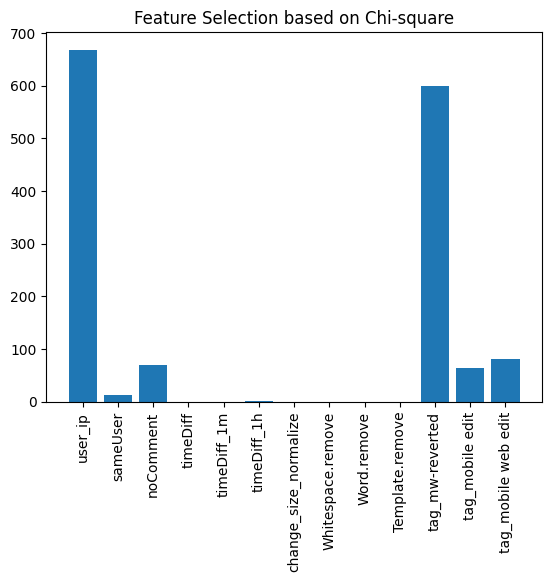

In [162]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

fs = SelectKBest(score_func=chi2, k='all')
features = ['user_ip','sameUser','noComment','timeDiff','timeDiff_1m','timeDiff_1h','change_size_normalize','Whitespace.remove','Word.remove','Template.remove','tag_mw-reverted','tag_mobile edit','tag_mobile web edit']

X_train = df[features]
y_train = df['modelPredict'].to_list()

#X_train = df[['noComment','sameUser']][:4000]
#y_train = df['modelPredict'][:4000]

fs.fit(X_train, y_train)
X_train_fs = fs.transform(X_train)

for i in range(len(fs.scores_)):
    print('Feature {} ({}): {}'.format(i, features[i], round(fs.scores_[i],1)))

# plot the scores
#plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.bar(features, fs.scores_)
plt.xticks(rotation=90)
plt.title('Feature Selection based on Chi-square')
plt.show()


Feature 0 (user_ip): 0.1
Feature 1 (sameUser): 0.0
Feature 2 (noComment): 0.0
Feature 3 (timeDiff): 0.0
Feature 4 (timeDiff_1m): 0.0
Feature 5 (timeDiff_1h): 0.0
Feature 6 (change_size_normalize): 0.0
Feature 7 (Whitespace.remove): 0.0
Feature 8 (Word.remove): 0.0
Feature 9 (Template.remove): 0.0
Feature 10 (tag_mw-reverted): 0.0
Feature 11 (tag_mobile edit): 0.0
Feature 12 (tag_mobile web edit): 0.0


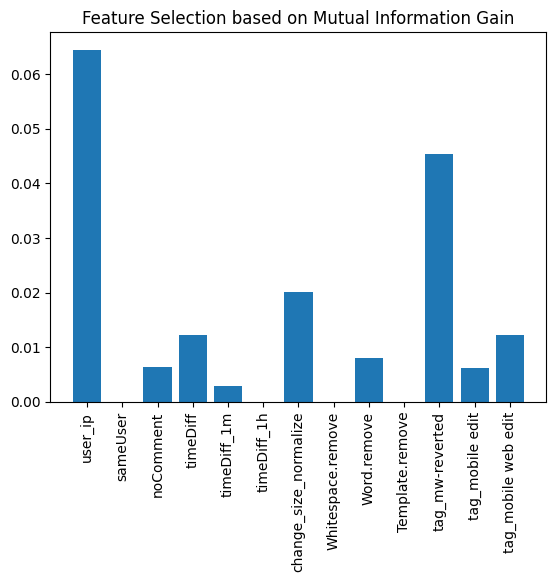

In [163]:
fs = SelectKBest(score_func=mutual_info_classif, k='all')

fs.fit(X_train, y_train)
X_train_fs = fs.transform(X_train)

for i in range(len(fs.scores_)):
    print('Feature {} ({}): {}'.format(i, features[i], round(fs.scores_[i],1)))

# plot the scores
plt.bar(features, fs.scores_)
plt.xticks(rotation=90)
plt.title('Feature Selection based on Mutual Information Gain')
plt.show()


### <span style="color:blue">Obversation and Comments:<span>

- Based on some more digging: it seems the tag 'mw-reverte' is automatically generated when an edit is reverted. So in reality before the edits were reviewed, this tag should not be available.

- Also it seems that the user_ip is a very strong indicator for damaging edits (at least according to the ORES model prediction)

- Other features selected: noComment, timeDiff, change_size, word.remove, tag_mobile edit and tag_mobile web edit

### <span style="color:blue"> Classification by Simple Decision Tree and Random Forest Classifiers <span>

- The aim here is to experiment with training decision tree and random forest classifiers and see how they performs as compared with the ORES model

In [179]:
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

select_features = ['user_ip','noComment','timeDiff','change_size_normalize','Word.remove','tag_mobile edit','tag_mobile web edit']
X = df[select_features]
y = df['modelPredict'].tolist()
#y = df['modelPredict'].to_numpy().astype('bool')

X_train = X[:4000]
y_train = y[:4000]

X_test = X[4000:]
y_test = y[4000:]


Decision Tree
Confusion matrix:
 [[841  48]
 [ 74  23]]

Report:
               precision    recall  f1-score   support

       False       0.92      0.95      0.93       889
        True       0.32      0.24      0.27        97

    accuracy                           0.88       986
   macro avg       0.62      0.59      0.60       986
weighted avg       0.86      0.88      0.87       986



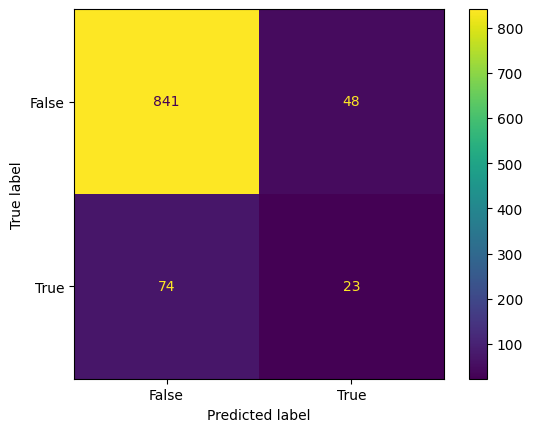

In [181]:
# Add decision tree classifier results

print('Decision Tree')
clf = DecisionTreeClassifier(random_state=1344)
#clf = RandomForestClassifier()

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Confusion matrix:\n',confusion_matrix(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
print('\nReport:\n', classification_report(y_test, y_pred,digits=2))

# Add decision tree visualization
#fig = plt.figure(figsize=(25,20))
#_ = tree.plot_tree(clf, feature_names=feature_names, class_names=['Damaging','Non-damaging'],filled=True)

#fig.savefig("decistion_tree.png")

Random Forest
Confusion matrix:
 [[876  13]
 [ 87  10]]

Report:
               precision    recall  f1-score   support

       False       0.91      0.99      0.95       889
        True       0.43      0.10      0.17        97

    accuracy                           0.90       986
   macro avg       0.67      0.54      0.56       986
weighted avg       0.86      0.90      0.87       986



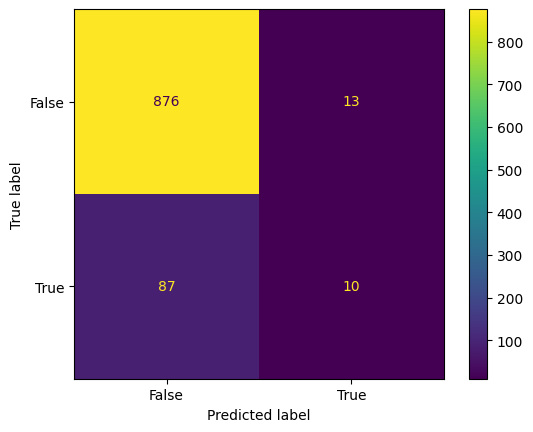

In [191]:
# Add random forest classifier results

print('Random Forest')
#clf = DecisionTreeClassifier(random_state=1344)
clf = RandomForestClassifier()

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Confusion matrix:\n',confusion_matrix(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
print('\nReport:\n', classification_report(y_test, y_pred,digits=2))


### <span style="color:blue"> Observation and Comments <span>

- Random Forest Classifier seems to have a better performance than Decision Tree Classifier based on overall accuracy level (90% vs 88%) and precision for the True class (43% vs 32%)

- However, the absoluate total number of true positives (i.e. damaging edits) captured by the decision tree almost doubles that of random forest (23 vs 10). This is also reflected in the higher recall of decsion treee (24%) vs random forest (10%), which means the decision tree is better at reducing the false negatives.


In [192]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier()

In [193]:
print('Grid search and cross validation:\n')
param_grid = {
                 'n_estimators': [100, 500, 1000],
                 'max_depth': [1, 3, 5, 7]
             }
grid_clf = GridSearchCV(clf, param_grid, cv=5)
grid_clf.fit(X_train, y_train)

y_pred = grid_clf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print('\nReport:\n', classification_report(y_test, y_pred,digits=2))


Grid search and cross validation:

[[889   0]
 [ 97   0]]
0.9016227180527383

Report:
               precision    recall  f1-score   support

       False       0.90      1.00      0.95       889
        True       0.00      0.00      0.00        97

    accuracy                           0.90       986
   macro avg       0.45      0.50      0.47       986
weighted avg       0.81      0.90      0.85       986



/srv/paws/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/srv/paws/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/srv/paws/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


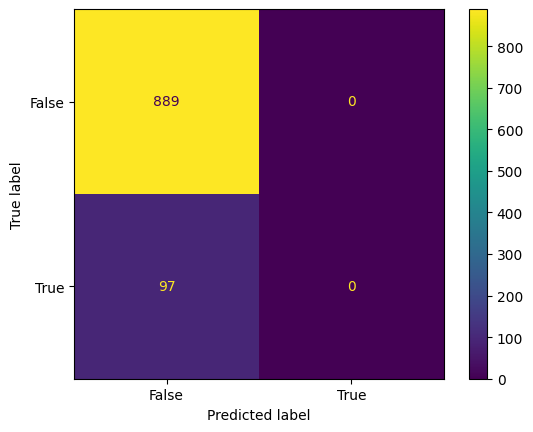

In [194]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)


### Observation and Comments

- Attempts at fine-tuning the Random Forest Classifier via grid search and cross-validation does not seem to return fruitful results.

- Need further investigation

# <span style="color:blue"> Investigation of Input Features in ORES Model <span>

- There are 78 input features in ORES model according to the web API

In [ ]:
import requests

# get model prediction, probablity and features
def ores_model_get_results(revids):
    '''Ores API recommends to process a batch of no more than 50 revisions within a given request
    '''
    prediction = []
    probability = []
    features = []
    batches = [revids[i:i+50] for i in range(0,len(revids),50)]
    for batch_ids in batches:
        revids_ = '|'.join(batch_ids)
        api_url = "https://ores.wikimedia.org/v3/scores/enwiki/?models=damaging&revids={}&features".format(revids_)
        #api_url = "https://ores.wikimedia.org/v3/scores/enwiki/{}/damaging?features".format(revids_)
        response = requests.get(api_url)
        scores = response.json()['enwiki']['scores']
        for revid in batch_ids:
            try:
                prediction.append(scores[revid]['damaging']['score']['prediction'])
                probability.append(scores[revid]['damaging']['score']['probability'])
                features.append(scores[revid]['damaging']['features'])
            except KeyError:
                #print(revid, scores[revid])
                prediction.append(scores[revid]['damaging']['error']['type'])
                probability.append(None)
                features.append(None)
    return prediction, probability, features

df_2 = pd.read_csv('enwiki_5000_v2.csv')
df_2['modelPredict'],df_2['probability'],df_2['features'] = ores_model_get_results(df_2['revid'].astype('string').to_list())


# expand probability and features into new columns
df_2 = pd.concat([df_2,pd.json_normalize(df_2['probability']),pd.json_normalize(df_2['features'])],axis=1)

df_2.to_csv("enwiki_5000_v2.csv")


In [264]:
df2 = pd.read_csv('enwiki_5000_v2.csv')
features = df2.columns[19:].tolist()
print('Number of input features to ORES model:', len(features))
for feature in features:
    print(feature)

Number of input features to ORES model: 78
feature.english.badwords.revision.diff.match_delta_decrease
feature.english.badwords.revision.diff.match_delta_increase
feature.english.badwords.revision.diff.match_delta_sum
feature.english.badwords.revision.diff.match_prop_delta_decrease
feature.english.badwords.revision.diff.match_prop_delta_increase
feature.english.badwords.revision.diff.match_prop_delta_sum
feature.english.dictionary.revision.diff.dict_word_delta_decrease
feature.english.dictionary.revision.diff.dict_word_delta_increase
feature.english.dictionary.revision.diff.dict_word_delta_sum
feature.english.dictionary.revision.diff.dict_word_prop_delta_decrease
feature.english.dictionary.revision.diff.dict_word_prop_delta_increase
feature.english.dictionary.revision.diff.dict_word_prop_delta_sum
feature.english.dictionary.revision.diff.non_dict_word_delta_decrease
feature.english.dictionary.revision.diff.non_dict_word_delta_increase
feature.english.dictionary.revision.diff.non_dict_w

In [265]:
# Missing data in the input features
df2[df2[features].isna().sum(axis=1)!=0]

,Unnamed: 0.1,Unnamed: 0,type,ns,title,pageid,revid,old_revid,rcid,user,...,feature.wikitext.revision.parent.external_links,feature.wikitext.revision.parent.headings,feature.wikitext.revision.parent.ref_tags,feature.wikitext.revision.parent.tags,feature.wikitext.revision.parent.templates,feature.wikitext.revision.parent.wikilinks,feature.wikitext.revision.ref_tags,feature.wikitext.revision.tags,feature.wikitext.revision.templates,feature.wikitext.revision.wikilinks
169,169,169,edit,0,Bernardo Rivavelarde,29687808,1114458722,1114458060,1556979005,139.47.74.164,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
522,522,522,edit,0,Bernardo Rivavelarde,29687808,1114459339,1114458722,1556980142,139.47.74.164,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
869,869,869,edit,0,Bernardo Rivavelarde,29687808,1114459964,1114459339,1556981146,139.47.74.164,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1204,1204,1204,edit,0,Bernardo Rivavelarde,29687808,1114460579,1114459964,1556982131,139.47.74.164,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1818,1818,1818,edit,0,Annie (2014 film),39830751,1114461707,1109676087,1556983963,Ladyoftrees,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1894,1894,1894,edit,0,Annie (2014 film),39830751,1114461849,1114461707,1556984169,Ladyoftrees,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1957,1957,1957,edit,0,Annie (2014 film),39830751,1114461969,1114461849,1556984385,Ladyoftrees,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4907,4907,4907,edit,0,Under Suspicion (1930 film),46878563,1114467492,1108768950,1556993476,Infodistracted,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [269]:
# dealing with missing data
df2 = df2[df2[features].isna().sum(axis=1)==0]

df2[features].describe()

,feature.english.badwords.revision.diff.match_delta_decrease,feature.english.badwords.revision.diff.match_delta_increase,feature.english.badwords.revision.diff.match_delta_sum,feature.english.badwords.revision.diff.match_prop_delta_decrease,feature.english.badwords.revision.diff.match_prop_delta_increase,feature.english.badwords.revision.diff.match_prop_delta_sum,feature.english.dictionary.revision.diff.dict_word_delta_decrease,feature.english.dictionary.revision.diff.dict_word_delta_increase,feature.english.dictionary.revision.diff.dict_word_delta_sum,feature.english.dictionary.revision.diff.dict_word_prop_delta_decrease,...,feature.wikitext.revision.parent.external_links,feature.wikitext.revision.parent.headings,feature.wikitext.revision.parent.ref_tags,feature.wikitext.revision.parent.tags,feature.wikitext.revision.parent.templates,feature.wikitext.revision.parent.wikilinks,feature.wikitext.revision.ref_tags,feature.wikitext.revision.tags,feature.wikitext.revision.templates,feature.wikitext.revision.wikilinks
count,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,...,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000
mean,-0.013421,0.024038,0.010617,-0.004950,0.015703,0.010753,-9.870793,16.161859,6.291066,-3.012191,...,48.928486,13.572115,53.202524,303.698317,96.960938,175.188502,53.318109,304.298878,97.255809,175.647035
std,0.264852,0.389482,0.470410,0.085325,0.274084,0.286981,160.957996,170.601105,231.673295,38.446686,...,100.039587,18.661738,103.835366,756.345638,186.015106,290.872438,103.739047,756.860811,186.072742,290.747334
min,-13.000000,0.000000,-13.000000,-3.000000,0.000000,-3.000000,-10589.000000,0.000000,-10589.000000,-2411.710062,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.000000,0.000000,0.000000,-1.000000,...,5.000000,5.000000,6.000000,26.000000,15.000000,35.000000,6.000000,26.000000,16.000000,35.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,16.000000,9.000000,17.000000,89.000000,35.000000,79.000000,17.000000,89.000000,35.000000,80.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,5.000000,0.000000,...,46.000000,17.000000,54.000000,272.000000,98.000000,200.000000,55.000000,271.250000,98.000000,201.000000
max,0.000000,17.000000,17.000000,0.000000,13.000000,13.000000,0.000000,10865.000000,10864.000000,0.000000,...,2007.000000,343.000000,1331.000000,13547.000000,2428.000000,5994.000000,1331.000000,13562.000000,2430.000000,5999.000000


Analysis of Input Features in ORES model based on Mutual Information

Feature 0 (feature.english.badwords.revision.diff.match_delta_decrease): 0.0023790207416922726
Feature 1 (feature.english.badwords.revision.diff.match_delta_increase): 0.0
Feature 2 (feature.english.badwords.revision.diff.match_delta_sum): 0.0
Feature 3 (feature.english.badwords.revision.diff.match_prop_delta_decrease): 0.0
Feature 4 (feature.english.badwords.revision.diff.match_prop_delta_increase): 0.0035988545625831314
Feature 5 (feature.english.badwords.revision.diff.match_prop_delta_sum): 0.0027110724144072673
Feature 6 (feature.english.dictionary.revision.diff.dict_word_delta_decrease): 0.0
Feature 7 (feature.english.dictionary.revision.diff.dict_word_delta_increase): 0.003001991022964834
Feature 8 (feature.english.dictionary.revision.diff.dict_word_delta_sum): 0.0
Feature 9 (feature.english.dictionary.revision.diff.dict_word_prop_delta_decrease): 0.002273393861224271
Feature 10 (feature.english.dictionary.revi

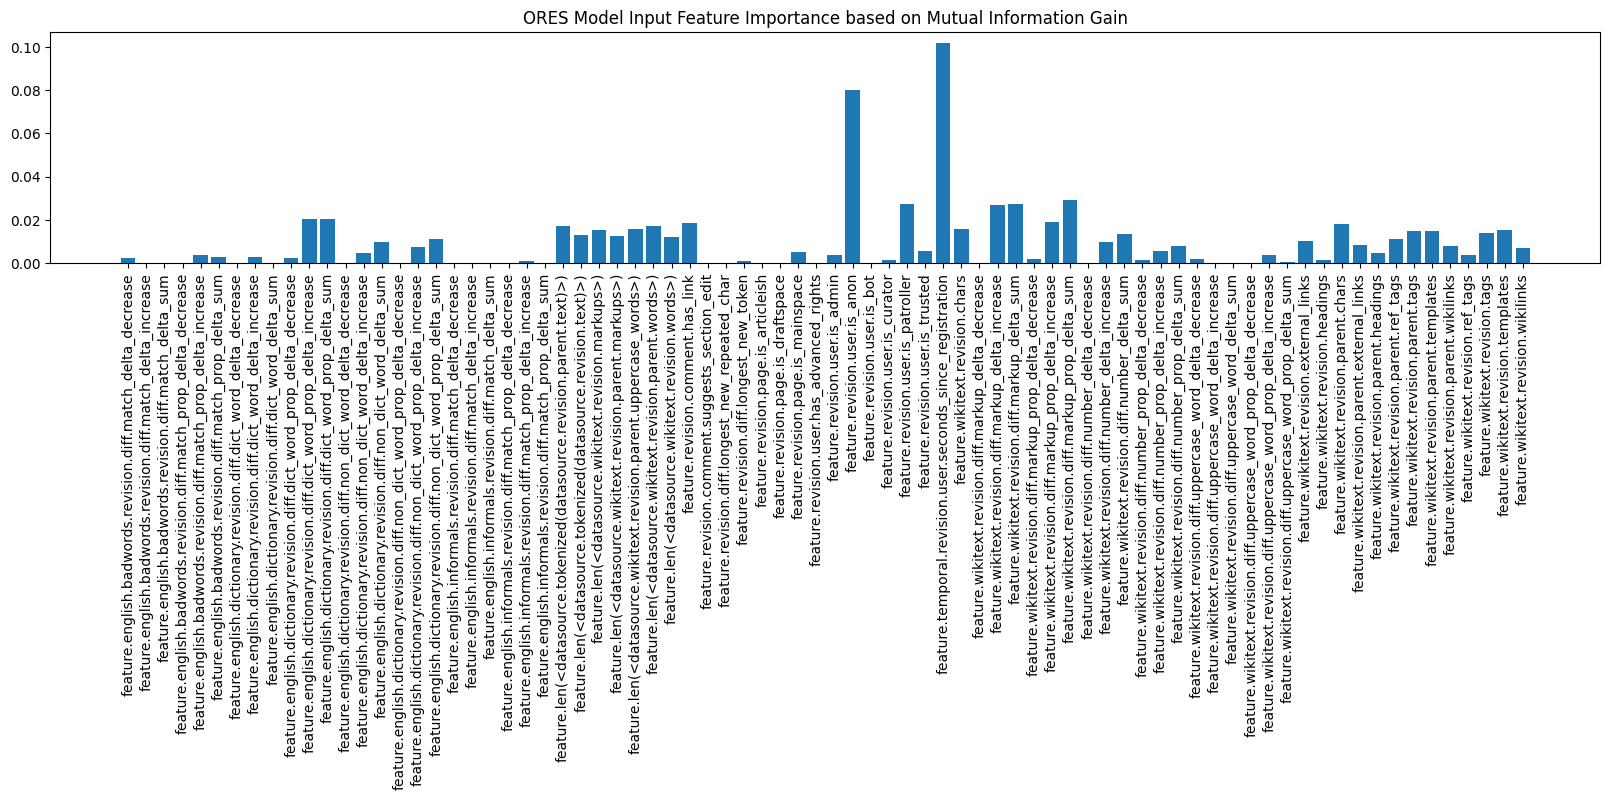

In [276]:
print('Analysis of Input Features in ORES model based on Mutual Information\n') 
fs = SelectKBest(score_func=mutual_info_classif, k='all')

# need to transform input data to non-negative
X_train = df2[features]
y_train = df2['modelPredict']

fs.fit(X_train, y_train)
fs.transform(X_train)

for i in range(len(fs.scores_)):
    print('Feature {} ({}): {}'.format(i, features[i], fs.scores_[i]))


    # plot the scores

plt.figure(figsize=(20,3))
plt.bar(features, fs.scores_)
plt.xticks(rotation=90)
plt.title('ORES Model Input Feature Importance based on Mutual Information Gain')
plt.show()


### <span style="color:blue"> Observation and Comments <span>

From the above analysis, we can observe out of the 78 input features to the ORES model, there are two in particular that play a predominant role in determining the classification: 

- Feature 45 (feature.temporal.revision.user.seconds_since_registration)

- Feature 40 (feature.revision.user.is_anon)

This probably implies that the ORES model relies predominantly on the user information such as whether user ID is anonymous and history of the user's registration to predict damaging edits.

In [609]:
# Note: can't do batches of 50 as some entries does not have a page id (deleted?) so can't match the size
# response = session.get(action='query', prop='revisions', rvslots='main',revids=df['revid'][-50:],rvprop='comment')
# print(len(df['revid'][-50:]), len(response['query']['pages'].keys())) #50, 48

def getComment(revids):
    comments = []
    batches = [revids[i:i+10] for i in range(0,len(revids),10)]
    for revids_ in batches:
        response = session.get(action='query', prop='revisions', rvslots='main',revids=revids_,rvprop='comment')
        for k in response['query']['pages'].keys():
            try:
                comments.append(response['query']['pages'][k]['revisions'][0]['comment'])
            except KeyError:
                comments.append(None)
    return comments

# demo that it does not work for batches - to investigate
revids_ = df['revid'][-25:-20]
#revids_ = df['revid'][-10:]
response = session.get(action='query', prop='revisions', rvslots='main',revids=revids_,rvprop='comment|ids|tags|size')
print(len(revids_), len(response['query']['pages'].keys()))

ids=[]
for k in response['query']['pages'].keys():
    ids.append(response['query']['pages'][k]['revisions'][0]['revid'])

ids_=[]
for i in revids_:
    if i not in ids:
        print(i)
        ids_.append(i)
response = session.get(action='query', prop='revisions', rvslots='*',revids=ids_,rvprop='comment|ids|tags|size')
#print(len(df['revid'][-50:]), len(response['query']['pages'].keys())) #50, 48
response

5 4
1114467585


{'batchcomplete': '',
 'query': {'pages': {'27908597': {'pageid': 27908597,
    'ns': 0,
    'title': 'No Love',
    'revisions': [{'revid': 1114467585,
      'parentid': 1114467581,
      'size': 33791,
      'comment': 'Reverting possible vandalism by [[Special:Contribs/182.79.4.252|182.79.4.252]] to version by 24.115.123.109. [[WP:CBFP|Report False Positive?]] Thanks, [[WP:CBNG|ClueBot NG]]. (4179811) (Bot)',
      'tags': ['mw-rollback']}]}}}}

# <span style="color:blue"> ORES Model Prediction vs Actual Reverts <span>

This [mwreverts.api library](https://pythonhosted.org/mwreverts/) provides a set of utilities for detecting reverts and identifying the reverted status of edits to a MediaWiki wiki. Same author as the ORES model - Aaron Halfaker – https://github.com/halfak

Get the actual reverted status (as ground truth) and compare twith the ORES model prediction.

In [1]:
!pip install mwreverts

In [2]:
import mwapi, mwreverts.api

In [3]:
session = mwapi.Session(
    host="https://en.wikipedia.org",
    user_agent="Outreachy round fall 2022"
)

reverting, reverted, reverted_to = mwreverts.api.check(session, rev_id=1114458453, page_id=None, radius=1, before=None, window=None, rvprop=None)
# https://pythonhosted.org/mwreverts/api.html
#1114458453 - model prdict True
print(reverted)
# reverting – If this edit reverted other edit(s)
# reverted – If this edit was reverted by another edit
# reverted_to – If this edit was reverted to by another edit

None


In [8]:
df = pd.read_csv("enwiki_5000.csv")

In [ ]:
df[df['modelPredict']=='True']['revid'] #379
groundTruth = []
for revid,pageid in zip(df['revid'],df['pageid']):
    try:
        reverting, reverted, reverted_to = mwreverts.api.check(session, rev_id=revid, page_id=pageid, radius=1, before=None, window=None, rvprop=None)
        #print(reverting, reverted, reverted_to)
        if reverted:
            groundTruth.append(True)
        else:
            groundTruth.append(False)
    except KeyError:
        groundTruth.append(None)
        


In [30]:
#len(groundTruth)

df['groundTruth'] = groundTruth
df.to_csv("enwiki_5000.csv")


4966
False    4659
True      307
Name: groundTruth, dtype: int64 4966
False    4587
True      379
Name: modelPredict, dtype: int64 4966
Confusion matrix:
 [[0.88461538 0.05356424]
 [0.03906565 0.02275473]]

Accuracy: 0.9073701167942005

Report:
               precision    recall  f1-score   support

       False       0.96      0.94      0.95      4659
        True       0.30      0.37      0.33       307

    accuracy                           0.91      4966
   macro avg       0.63      0.66      0.64      4966
weighted avg       0.92      0.91      0.91      4966



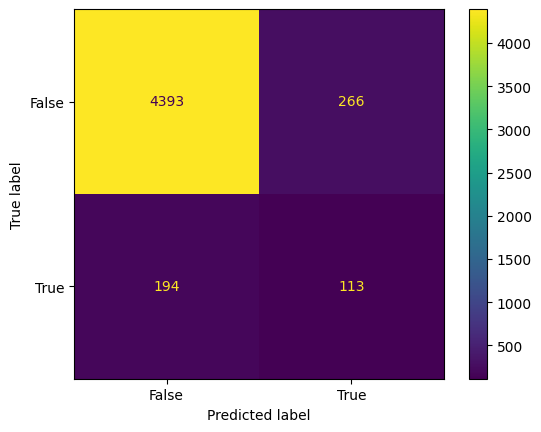

In [84]:
df_ = df[['groundTruth','modelPredict','revid']].dropna()
print(len(df_))
print(df_['groundTruth'].value_counts(), df_['groundTruth'].count())
print(df_['modelPredict'].value_counts(), df_['modelPredict'].count())
#df[['groundTruth','modelPredict','title','pageid','revid','user','timestamp','old_revid','old_user','old_timestamp','ContentDiff','comment','tags','change_size']].isna().sum()

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
print('Confusion matrix:\n',confusion_matrix(df_['groundTruth'].to_list(), df_['modelPredict'].to_list())/len(df_))
print('\nAccuracy:',accuracy_score(df_['groundTruth'].to_list(), df_['modelPredict'].to_list()))
print('\nReport:\n', classification_report(df_['groundTruth'].to_list(), df_['modelPredict'].to_list(),digits=2))

ConfusionMatrixDisplay.from_predictions(df_['groundTruth'].to_list(), df_['modelPredict'].to_list())
#plt.show()

### <span style="color:blue"> Observation and Analysis <span>

- Here we can see that although the model has an overall accuracy of 91%, it is mainly helped by the overpoweringly imbalanced majority class (False, i.e. most of the edits are NOT reverted); the actual precision and recall for the True class (i.e. edits ARE reverted) are quite low, at 30% and 37%, respectively. This means that the ability of the model to catch reverted edits is not great. 
- It should also be noted that the ground truth that we are comparing the model with is the actual revertion. This might not be perfectly coincide with the damaging edits in reality - some reverted edits might be caused unintentionally, i.e. good-faithed, rather than truly vandalism. 
- Overall, we should aim primarily to minimize the false negatives (i.e. those damaging edits which have been predicted as good) and secondarily, reducing the false positives (which will likely increase the workload of patrollers)


### <span style="color:blue"> Potential Next Steps: <span>

Repeat the same analysis on the actual reverted edits (i.e. treating actual revertion as damaging edits) 

- The idea here is to see if there is any distinguishing features for **reverted** edits vs **non-reverted** edits so that we can filter out non-reverted edits as a first step.

- The **damaging** edits should be a *subset* of the reverted edits, so if we can first identify the reverted edits, we are effectively reducing the overall data size of the classification problem.